In [1]:
!pip install pyvi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 66.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import re
import json
import pickle
from pyvi.ViTokenizer import ViTokenizer

import seaborn as sn
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D, Bidirectional, GRU
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Model
from keras.utils import to_categorical
from keras.preprocessing import text, sequence
from keras.utils import pad_sequences
from keras import backend as K

from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

# **Preprocess**

In [3]:
label_id = list(pd.read_csv('/content/drive/MyDrive/Khai thác dữ liệu truyền thông xã hội - IE403.N22/Đồ án/Data/ViHSD/train.csv')['label_id'])

In [4]:
with open('/content/drive/MyDrive/Khai thác dữ liệu truyền thông xã hội - IE403.N22/Đồ án/Data/train_data.json', 'r') as json_data:
    train_data = json.load(json_data)
with open('/content/drive/MyDrive/Khai thác dữ liệu truyền thông xã hội - IE403.N22/Đồ án/Data/test_data.json', 'r') as json_data:
    test_data = json.load(json_data)
with open('/content/drive/MyDrive/Khai thác dữ liệu truyền thông xã hội - IE403.N22/Đồ án/Code/TextNormSeq2Seq/S2SMulti/valid.pred', 'r') as json_data:
    valid_res = json.load(json_data)
with open('/content/drive/MyDrive/Khai thác dữ liệu truyền thông xã hội - IE403.N22/Đồ án/Code/TextNormSeq2Seq/S2SMulti/test.pred', 'r') as json_data:
    test_res = json.load(json_data)

In [5]:
data = train_data + test_data
res = valid_res + test_res
inputs = []
for sent in data:
  inputs.append(sent['input'])

In [6]:
def find_indices(list_to_check, item_to_find):
    return [idx for idx, value in enumerate(list_to_check) if value == item_to_find]

In [7]:
for i in range(len(res)):
  id = res[i]['index']
  if(id < 3400):
    res[i]['label'] = label_id[id]

for i in range(len(res)):
  id = res[i]['index']
  if(id >= 3400):
    res[i]['label'] = label_id[min([data[i]['id'] for i in find_indices(inputs, res[i]['input'])])]

In [8]:
raw_text = []
norm_text = []
label = []

for sent in res:
  raw_text.append(sent['input'])
  norm_text.append(sent['output'])
  label.append(sent['label'])

In [9]:
print(len(raw_text))
print(len(norm_text))
print(len(label))

438
438
438


In [10]:
raw_texts = [(' ').join(text) for text in raw_text]
norm_texts = [(' ').join(text) for text in norm_text]

In [11]:
STOPWORDS = '/content/drive/MyDrive/Khai thác dữ liệu truyền thông xã hội - IE403.N22/Đồ án/Code/HSD/vietnamese-stopwords-dash.txt'
with open(STOPWORDS, "r") as ins:
    stopwords = []
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)
    stopwords = set(stopwords)

In [12]:
def filter_stop_words(sentences, stop_words):
    new_sent = [word for word in sentences.split() if word not in stop_words]
    sentences = ' '.join(new_sent)

    return sentences

def preprocess(text, tokenized = True):
    text = ViTokenizer.tokenize(text) if tokenized else text
    text = filter_stop_words(text, stopwords)
    return text

# --------------TRICH XUAT DAC TRUNG -------------------------
def pre_process_features(X, y, tokenized = True):
    X = [preprocess(str(p), tokenized = tokenized) for p in X]
    for idx, ele in enumerate(X):
        if not ele:
            np.delete(X, idx)
            np.delete(y, idx)
    return X, y

# **Run Models**

## Text CNN (Convolutional neural network for text classification)

In [13]:
vocabulary_size = 10000
sequence_length = 100

embedding_dim = 300
batch_size = 256
epochs = 40
drop = 0.5

filter_sizes = [2,3,5]
num_filters = 32

### Non-normalized Texts

In [23]:
X_train, X_test, y_train, y_test = train_test_split(raw_texts, label, test_size=0.1, random_state=42)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [24]:
train_X, train_y = pre_process_features(X_train, y_train, tokenized=True)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=True)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=True)

EMBEDDING_FILE = '/content/drive/MyDrive/Khai thác dữ liệu truyền thông xã hội - IE403.N22/Đồ án/Code/HSD/cc.vi.300.vec'
MODEL_FILE = '/content/drive/MyDrive/Khai thác dữ liệu truyền thông xã hội - IE403.N22/Đồ án/Code/HSD/model/Text_CNN_model_raw.h5'


In [25]:
def make_featues(X, y, tokenizer, is_one_hot_label=True):
    X = tokenizer.texts_to_sequences(X)
    X = pad_sequences(X, maxlen=sequence_length)
    if is_one_hot_label:
        y = to_categorical(y, num_classes=3)

    return X, y

In [26]:
# --------------LOAD WORD EMBEDDING -------------------------
embeddings_index = {}
with open(EMBEDDING_FILE, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


tokenizer = text.Tokenizer(lower=False, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(train_X)
with open('/content/drive/MyDrive/Khai thác dữ liệu truyền thông xã hội - IE403.N22/Đồ án/Code/HSD/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

word_index = tokenizer.word_index
# num_words = min(vocabulary_size, len(word_index) + 1)
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= vocabulary_size:
        continue

    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [27]:
train_X, train_y = make_featues(train_X, train_y, tokenizer)
dev_X, dev_y = make_featues(dev_X, dev_y, tokenizer)
test_X, test_y = make_featues(test_X, test_y, tokenizer, is_one_hot_label=False)


inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=sequence_length, weights=[embedding_matrix])(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=3, activation='softmax')(dropout)

In [28]:
# this creates a model that includes
model = Model(inputs=inputs, outputs=output)

model.summary()

checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data=(dev_X, dev_y))
model.save(MODEL_FILE)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 100, 300)     412500      ['input_2[0][0]']                
                                                                                                  
 reshape_1 (Reshape)            (None, 100, 300, 1)  0           ['embedding_1[0][0]']            
                                                                                                  
 conv2d_3 (Conv2D)              (None, 99, 1, 32)    19232       ['reshape_1[0][0]']              
                                                                                            

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2/2 [==============================] - 1s 229ms/step - loss: 1.2408 - accuracy: 0.2232 - val_loss: 1.1452 - val_accuracy: 0.2250
Epoch 2/40
2/2 [==============================] - 0s 42ms/step - loss: 1.2232 - accuracy: 0.2147 - val_loss: 1.1257 - val_accuracy: 0.3000
Epoch 3/40
2/2 [==============================] - 0s 51ms/step - loss: 1.2046 - accuracy: 0.2458 - val_loss: 1.1069 - val_accuracy: 0.3250
Epoch 4/40
2/2 [==============================] - 0s 43ms/step - loss: 1.1431 - accuracy: 0.3277 - val_loss: 1.0891 - val_accuracy: 0.3750
Epoch 5/40
2/2 [==============================] - 0s 41ms/step - loss: 1.1468 - accuracy: 0.2994 - val_loss: 1.0720 - val_accuracy: 0.4250
Epoch 6/40
2/2 [==============================] - 0s 41ms/step - loss: 1.1014 - accuracy: 0.3785 - val_loss: 1.0556 - val_accuracy: 0.5500
Epoch 7/40
2/2 [==============================] - 0s 42ms/step - loss: 1.0742 - accuracy: 0.4124 - val_loss: 1.0399 - val_accuracy: 0.5750
Epoch 8/40
2/2 [=====================

[[33  0  0]
 [ 2  0  0]
 [ 8  0  1]]
F1 - micro: 0.7727272727272727
F1 - macro: 0.356140350877193
Accuracy: 0.7727272727272727


<Axes: >

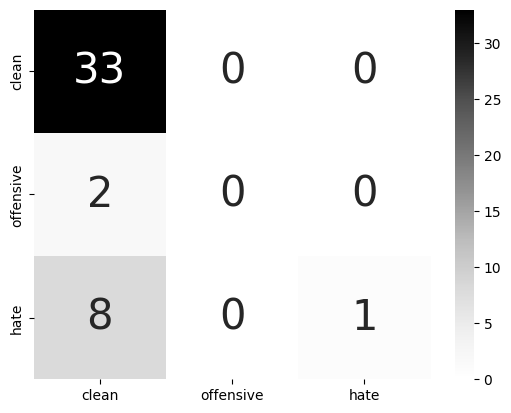

In [29]:
prediction = model.predict(test_X, batch_size=batch_size, verbose=0)
y_pred = prediction.argmax(axis=-1)

cf1 = confusion_matrix(test_y, y_pred)
print(cf1)

evaluation = f1_score(test_y, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(test_y, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

evaluation = accuracy_score(test_y, y_pred)
print("Accuracy: " + str(evaluation))

df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

### Normalized Texts

In [30]:
X_train, X_test, y_train, y_test = train_test_split(norm_texts, label, test_size=0.1, random_state=42)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [31]:
train_X, train_y = pre_process_features(X_train, y_train, tokenized=True)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=True)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=True)

EMBEDDING_FILE = '/content/drive/MyDrive/Khai thác dữ liệu truyền thông xã hội - IE403.N22/Đồ án/Code/HSD/cc.vi.300.vec'
MODEL_FILE = '/content/drive/MyDrive/Khai thác dữ liệu truyền thông xã hội - IE403.N22/Đồ án/Code/HSD/model/Text_CNN_model_norm.h5'


In [32]:
def make_featues(X, y, tokenizer, is_one_hot_label=True):
    X = tokenizer.texts_to_sequences(X)
    X = pad_sequences(X, maxlen=sequence_length)
    if is_one_hot_label:
        y = to_categorical(y, num_classes=3)

    return X, y

In [33]:
# --------------LOAD WORD EMBEDDING -------------------------
embeddings_index = {}
with open(EMBEDDING_FILE, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


tokenizer = text.Tokenizer(lower=False, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(train_X)
with open('/content/drive/MyDrive/Khai thác dữ liệu truyền thông xã hội - IE403.N22/Đồ án/Code/HSD/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

word_index = tokenizer.word_index
# num_words = min(vocabulary_size, len(word_index) + 1)
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= vocabulary_size:
        continue

    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [34]:
train_X, train_y = make_featues(train_X, train_y, tokenizer)
dev_X, dev_y = make_featues(dev_X, dev_y, tokenizer)
test_X, test_y = make_featues(test_X, test_y, tokenizer, is_one_hot_label=False)


inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=sequence_length, weights=[embedding_matrix])(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=3, activation='softmax')(dropout)

In [35]:
# this creates a model that includes
model = Model(inputs=inputs, outputs=output)

model.summary()

checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data=(dev_X, dev_y))
model.save(MODEL_FILE)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 100, 300)     355500      ['input_3[0][0]']                
                                                                                                  
 reshape_2 (Reshape)            (None, 100, 300, 1)  0           ['embedding_2[0][0]']            
                                                                                                  
 conv2d_6 (Conv2D)              (None, 99, 1, 32)    19232       ['reshape_2[0][0]']              
                                                                                            

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2/2 [==============================] - 1s 222ms/step - loss: 1.0877 - accuracy: 0.5254 - val_loss: 1.0815 - val_accuracy: 0.6500
Epoch 2/40
2/2 [==============================] - 0s 49ms/step - loss: 1.0479 - accuracy: 0.5819 - val_loss: 1.0713 - val_accuracy: 0.6500
Epoch 3/40
2/2 [==============================] - 0s 41ms/step - loss: 1.0487 - accuracy: 0.5791 - val_loss: 1.0612 - val_accuracy: 0.6500
Epoch 4/40
2/2 [==============================] - 0s 42ms/step - loss: 1.0371 - accuracy: 0.5734 - val_loss: 1.0515 - val_accuracy: 0.7000
Epoch 5/40
2/2 [==============================] - 0s 41ms/step - loss: 0.9959 - accuracy: 0.6299 - val_loss: 1.0424 - val_accuracy: 0.7250
Epoch 6/40
2/2 [==============================] - 0s 40ms/step - loss: 1.0111 - accuracy: 0.6299 - val_loss: 1.0339 - val_accuracy: 0.7250
Epoch 7/40
2/2 [==============================] - 0s 44ms/step - loss: 0.9423 - accuracy: 0.6638 - val_loss: 1.0256 - val_accuracy: 0.7250
Epoch 8/40
2/2 [=====================

[[33  0  0]
 [ 2  0  0]
 [ 7  0  2]]
F1 - micro: 0.7954545454545455
F1 - macro: 0.41454545454545455
Accuracy: 0.7954545454545454


<Axes: >

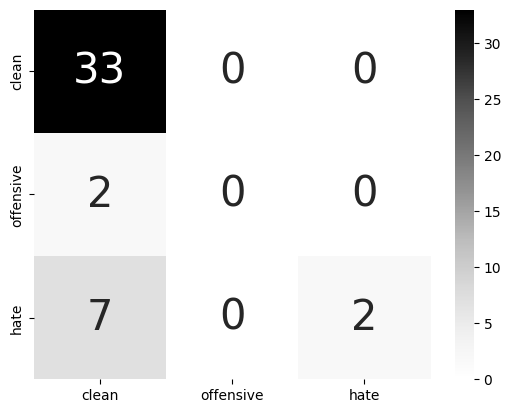

In [36]:
prediction = model.predict(test_X, batch_size=batch_size, verbose=0)
y_pred = prediction.argmax(axis=-1)

cf1 = confusion_matrix(test_y, y_pred)
print(cf1)

evaluation = f1_score(test_y, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(test_y, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

evaluation = accuracy_score(test_y, y_pred)
print("Accuracy: " + str(evaluation))

df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

## GRU (Gated Recurrent Units)

In [13]:
vocabulary_size = 10000
sequence_length = 100

embedding_dim = 300
batch_size = 256
epochs = 40
drop = 0.5

### Non-normalized Texts

In [14]:
X_train, X_test, y_train, y_test = train_test_split(raw_texts, label, test_size=0.1, random_state=42)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [15]:
train_X, train_y = pre_process_features(X_train, y_train, tokenized=True)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=True)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=True)

EMBEDDING_FILE = '/content/drive/MyDrive/Khai thác dữ liệu truyền thông xã hội - IE403.N22/Đồ án/Code/HSD/cc.vi.300.vec'
MODEL_FILE = '/content/drive/MyDrive/Khai thác dữ liệu truyền thông xã hội - IE403.N22/Đồ án/Code/HSD/model/GRU_model_raw.h5'

In [16]:
def make_featues(X, y, tokenizer, is_one_hot_label=True):
    X = tokenizer.texts_to_sequences(X)
    X = pad_sequences(X, maxlen=sequence_length)
    if is_one_hot_label:
        y = to_categorical(y, num_classes=3)

    return X, y

In [18]:
embeddings_index = {}
with open(EMBEDDING_FILE, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

tokenizer = text.Tokenizer(lower=False, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(train_X)
with open('/content/drive/MyDrive/Khai thác dữ liệu truyền thông xã hội - IE403.N22/Đồ án/Code/HSD/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
# --------------LOAD WORD EMBEDDING-------------------------
word_index = tokenizer.word_index
# num_words = min(vocabulary_size, len(word_index) + 1)
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= vocabulary_size:
        continue

    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [20]:
train_X, train_y = make_featues(train_X, train_y, tokenizer)
dev_X, dev_y = make_featues(dev_X, dev_y, tokenizer)
test_X, test_y = make_featues(test_X, test_y, tokenizer, is_one_hot_label=False)

In [21]:
input = Input(shape=(sequence_length,))
x = Embedding(num_words, embedding_dim, weights=[embedding_matrix])(input)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(80, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
output = Dense(3, activation="softmax")(conc)

# this creates a model that includes
model = Model(inputs=input, outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 300)     412500      ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 100, 300)    0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, 100, 160)     183360      ['spatial_dropout1d[0][0]']  

In [22]:
# checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(dev_X, dev_y))
model.save(MODEL_FILE)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/40
2/2 [==============================] - 10s 770ms/step - loss: 1.0697 - accuracy: 0.5508 - val_loss: 1.0579 - val_accuracy: 0.6500
Epoch 2/40
2/2 [==============================] - 0s 68ms/step - loss: 1.0599 - accuracy: 0.5791 - val_loss: 1.0483 - val_accuracy: 0.7000
Epoch 3/40
2/2 [==============================] - 0s 57ms/step - loss: 1.0512 - accuracy: 0.6243 - val_loss: 1.0390 - val_accuracy: 0.7250
Epoch 4/40
2/2 [==============================] - 0s 54ms/step - loss: 1.0376 - accuracy: 0.6667 - val_loss: 1.0299 - val_accuracy: 0.7250
Epoch 5/40
2/2 [==============================] - 0s 51ms/step - loss: 1.0292 - accuracy: 0.6808 - val_loss: 1.0210 - val_accuracy: 0.7250
Epoch 6/40
2/2 [==============================] - 0s 47ms/step - loss: 1.0177 - accuracy: 0.6836 - val_loss: 1.0121 - val_accuracy: 0.7250
Epoch 7/40
2/2 [==============================] - 0s 47ms/step - loss: 1.0080 - accuracy: 0.7006 - val_loss: 1.0034 - val_accuracy: 0.7250
Epoch 8/40
2/2 [=========

[[33  0  0]
 [ 2  0  0]
 [ 9  0  0]]
F1 - micro: 0.75
F1 - macro: 0.2857142857142857
Accuracy: 0.75


<Axes: >

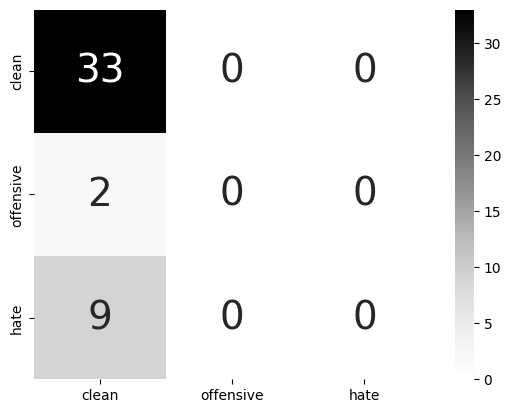

In [23]:
prediction = model.predict(test_X, batch_size=batch_size, verbose=0)
y_pred = prediction.argmax(axis=-1)

cf2 = confusion_matrix(test_y, y_pred)
print(cf2)

evaluation = f1_score(test_y, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(test_y, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

evaluation = accuracy_score(test_y, y_pred)
print("Accuracy: " + str(evaluation))

df_cm2 = pd.DataFrame(cf2, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm2, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 28})

### Normalized Texts

In [24]:
X_train, X_test, y_train, y_test = train_test_split(norm_texts, label, test_size=0.1, random_state=42)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [25]:
train_X, train_y = pre_process_features(X_train, y_train, tokenized=True)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=True)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=True)

EMBEDDING_FILE = '/content/drive/MyDrive/Khai thác dữ liệu truyền thông xã hội - IE403.N22/Đồ án/Code/HSD/cc.vi.300.vec'
MODEL_FILE = '/content/drive/MyDrive/Khai thác dữ liệu truyền thông xã hội - IE403.N22/Đồ án/Code/HSD/model/GRU_model_norm.h5'

In [26]:
def make_featues(X, y, tokenizer, is_one_hot_label=True):
    X = tokenizer.texts_to_sequences(X)
    X = pad_sequences(X, maxlen=sequence_length)
    if is_one_hot_label:
        y = to_categorical(y, num_classes=3)

    return X, y

In [27]:
embeddings_index = {}
with open(EMBEDDING_FILE, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

tokenizer = text.Tokenizer(lower=False, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(train_X)
with open('/content/drive/MyDrive/Khai thác dữ liệu truyền thông xã hội - IE403.N22/Đồ án/Code/HSD/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [28]:
# --------------LOAD WORD EMBEDDING-------------------------
word_index = tokenizer.word_index
# num_words = min(vocabulary_size, len(word_index) + 1)
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= vocabulary_size:
        continue

    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [29]:
train_X, train_y = make_featues(train_X, train_y, tokenizer)
dev_X, dev_y = make_featues(dev_X, dev_y, tokenizer)
test_X, test_y = make_featues(test_X, test_y, tokenizer, is_one_hot_label=False)

In [30]:
input = Input(shape=(sequence_length,))
x = Embedding(num_words, embedding_dim, weights=[embedding_matrix])(input)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(80, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
output = Dense(3, activation="softmax")(conc)

# this creates a model that includes
model = Model(inputs=input, outputs=output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 100, 300)     355500      ['input_2[0][0]']                
                                                                                                  
 spatial_dropout1d_1 (SpatialDr  (None, 100, 300)    0           ['embedding_1[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 100, 160)    183360      ['spatial_dropout1d_1[0][0]

In [31]:
# checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(dev_X, dev_y))
model.save(MODEL_FILE)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2/2 [==============================] - 4s 755ms/step - loss: 1.1455 - accuracy: 0.2203 - val_loss: 1.1091 - val_accuracy: 0.4500
Epoch 2/40
2/2 [==============================] - 0s 59ms/step - loss: 1.1333 - accuracy: 0.2458 - val_loss: 1.1012 - val_accuracy: 0.4500
Epoch 3/40
2/2 [==============================] - 0s 56ms/step - loss: 1.1271 - accuracy: 0.2316 - val_loss: 1.0934 - val_accuracy: 0.4750
Epoch 4/40
2/2 [==============================] - 0s 56ms/step - loss: 1.1153 - accuracy: 0.2486 - val_loss: 1.0858 - val_accuracy: 0.5250
Epoch 5/40
2/2 [==============================] - 0s 61ms/step - loss: 1.1085 - accuracy: 0.2684 - val_loss: 1.0782 - val_accuracy: 0.6250
Epoch 6/40
2/2 [==============================] - 0s 50ms/step - loss: 1.0929 - accuracy: 0.3418 - val_loss: 1.0708 - val_accuracy: 0.6500
Epoch 7/40
2/2 [==============================] - 0s 48ms/step - loss: 1.0864 - accuracy: 0.3870 - val_loss: 1.0634 - val_accuracy: 0.7000
Epoch 8/40
2/2 [=====================

[[33  0  0]
 [ 2  0  0]
 [ 8  0  1]]
F1 - micro: 0.7727272727272727
F1 - macro: 0.356140350877193
Accuracy: 0.7727272727272727


<Axes: >

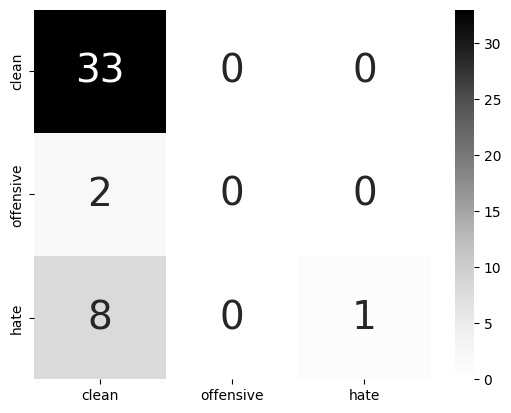

In [32]:
prediction = model.predict(test_X, batch_size=batch_size, verbose=0)
y_pred = prediction.argmax(axis=-1)

cf2 = confusion_matrix(test_y, y_pred)
print(cf2)

evaluation = f1_score(test_y, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(test_y, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

evaluation = accuracy_score(test_y, y_pred)
print("Accuracy: " + str(evaluation))

df_cm2 = pd.DataFrame(cf2, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm2, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 28})